# 3.利用隐变量解释

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/home/21031211625/anaconda3/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/21031211625/anaconda3/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "dataset_condition" # TODO: 批次key
cluster_key = "clusters" # TODO: 细胞类型key
pseudotime_key = "velocity_pseudotime"
adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


AnnData object with n_obs × n_vars = 7824 × 2000
    obs: 'sample_name', 'dataset_name', 'condition_code', 'condition', 'clusters', 'dataset_condition', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'condition_code_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'X_umap_old', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

## 2. 隐层表示提取

1. 提取隐变量

In [3]:
# velovgi_model = velovgi.tl.VELOVGI.load("model/base", adata=adata, use_gpu=True) # TODO: 需要根据gpu进行调换
velovgi_model = velovgi.tl.VELOVGI.load("model/base", adata=adata, use_gpu=False) # TODO: 需要根据gpu进行调换
latent_umap_key = "X_latent_umap"
velovgi.tl.get_latent_umap(adata, velovgi_model, latent_umap_key=latent_umap_key)

INFO     File model/base/model.pt already downloaded                                                               


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 7824 × 2000
    obs: 'sample_name', 'dataset_name', 'condition_code', 'condition', 'clusters', 'dataset_condition', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'condition_code_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_umap_old', 'velocity_umap', 'X_latent', 'X_latent_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. 隐变量的降维速率图

computing velocity embedding


    finished (0:00:01) --> added
    'velocity_latent_umap', embedded velocity vectors (adata.obsm)


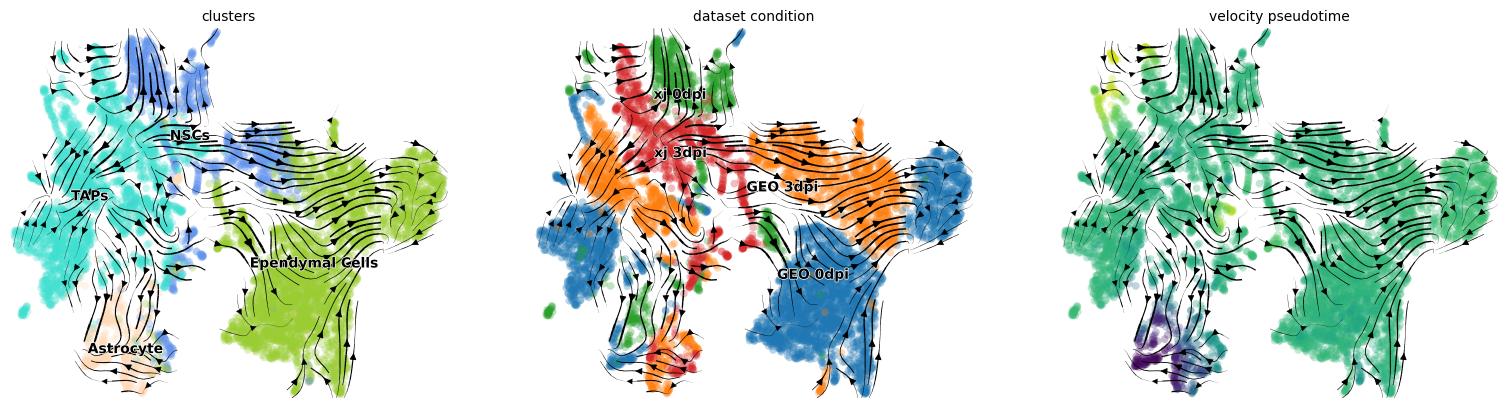

In [4]:
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key, pseudotime_key], basis=latent_umap_key, colorbar=False)

In [5]:
import numpy as np

# 保存降维结果
np.savetxt("output/latent_umap.txt", adata.obsm["X_latent_umap"])

## 2. 利用网络权重理解

Text(70.72222222222221, 0.5, 'Latent Dimensions')

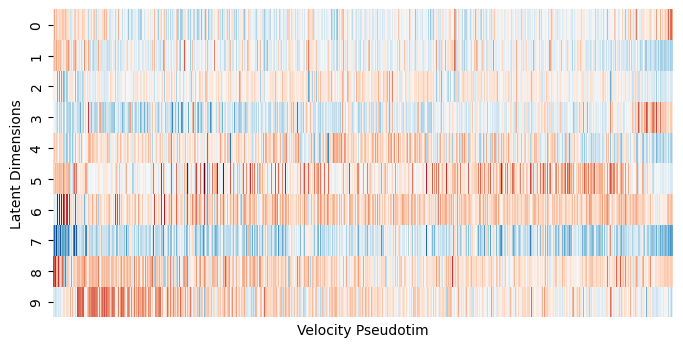

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (8, 4)
plt.figure(figsize=figsize)

# 隐变量排序
sorted_index = adata.obs["velocity_pseudotime"].sort_values().index
sorted_adata = adata[sorted_index]
latent_reprentation = sorted_adata.obsm["X_latent"]

# 显示聚类相关的颜色
color_dict = dict(zip(adata.obs[cluster_key].cat.categories, adata.uns["%s_colors"%cluster_key]))
color_list = adata.obs[cluster_key].apply(lambda x: color_dict[x]).to_numpy()

# 绘制隐变量热图
# sns.clustermap(latent_reprentation, row_cluster=False, col_cluster=False, row_colors=color_list, cbar_pos=(1, 0.05, 0.05, 0.3), cmap="RdBu_r")
sns.heatmap(latent_reprentation.T, cmap="RdBu_r", cbar=False) # 不要颜色条
plt.xticks([])
plt.xlabel("Velocity Pseudotim")
plt.ylabel("Latent Dimensions")

2. 编码器的特征提取整体与部分权重可视化

<Axes: >

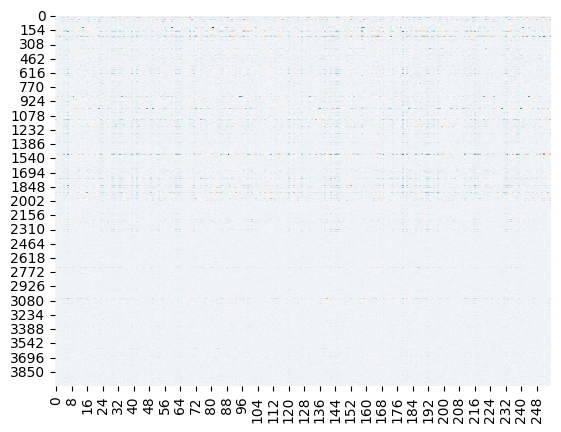

In [7]:
import numpy as np

gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
sns.heatmap(gcn_weight.T, cmap="RdBu_r", cbar=False)

[906, 767, 147, 1641, 81, 1945, 1663, 1475, 670, 415, 1498, 1795, 221, 832, 1092, 583, 792, 2737, 1241, 1168, 1738, 215, 3744, 261, 1118, 1029, 1914, 451, 1445, 170, 2873, 3592, 1507, 320, 32, 391, 268, 1370, 303, 852, 1524, 1015, 932, 1009, 202, 1453, 1196, 1612, 60, 1928, 780, 1000, 322, 196, 1073, 1984, 1810, 1672, 296, 1762, 200, 1657, 3611, 647, 833, 2560, 986, 1909, 505, 15, 707, 1192, 277, 1597, 37, 233, 874, 39, 3297, 1755, 1111, 466, 174, 909, 1675, 167, 1161, 1119, 757, 1321, 1833, 1758, 304, 966, 1991, 1590, 1598, 691, 1480, 367]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Cfl1,-0.227378,0.086736,0.572894,-0.359856,-0.654603,0.238810,-0.776138,-0.330267,-0.010477,-0.146687,...,-0.429499,-0.060746,-0.312068,0.080815,-0.119945,-0.276146,0.950588,0.197802,-0.330851,0.418010
Tubb5,0.521104,-0.069721,0.555989,0.350687,-0.268375,-0.552541,-0.383088,0.224557,-0.366191,0.333146,...,-0.319419,-0.138270,0.010663,-0.375906,0.474602,-0.480065,0.758781,0.149076,-0.074472,0.311113
Marcks,0.309987,0.230257,0.099816,0.123641,-0.403279,0.297846,-0.544877,0.267891,-0.127328,0.193442,...,-0.054396,-0.117953,-0.276612,0.393178,-0.061211,0.148881,0.305610,-0.088083,-0.014598,-0.145878
Arl6ip1,0.352272,0.059474,0.045934,0.253631,-0.259098,-0.538762,-0.443990,0.073448,-0.441102,0.284157,...,-0.514163,-0.032040,0.011067,-0.248721,0.081328,-0.182584,0.004476,0.060422,-0.034307,0.575691
1500015O10Rik,-0.464405,-0.033285,-0.469045,-0.128438,-0.340098,0.031459,-0.360612,0.083039,0.338293,-0.108605,...,0.352391,0.126745,-0.303884,0.371805,-0.199694,-0.011273,-0.057656,-0.151569,0.385813,0.157833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fosb,0.146836,0.020780,0.133959,0.016475,-0.052034,-0.036922,0.059656,-0.008814,0.145647,-0.068435,...,-0.147487,-0.060226,-0.131125,-0.268461,0.173713,0.081181,0.198134,-0.047026,-0.040339,-0.025607
Zfp36,0.101227,-0.003837,-0.247610,0.269991,0.085450,-0.078656,0.158288,0.205345,0.299325,-0.066531,...,-0.001793,-0.004905,-0.010484,-0.021078,-0.305874,0.075151,0.432825,-0.037041,-0.213889,0.037564
Nr4a1,0.106459,-0.044536,-0.042573,0.058353,-0.124287,-0.075209,-0.140129,0.052650,0.220897,-0.319297,...,-0.109762,-0.000053,-0.023110,-0.153956,0.043687,0.003716,0.425247,-0.035965,-0.089246,-0.277001
Rarres2,0.034578,0.039081,-0.288016,0.100164,-0.060940,-0.003227,-0.090565,0.238384,0.084936,0.069079,...,0.029587,0.024365,-0.056325,-0.030709,0.173780,-0.247383,0.440597,-0.110047,0.310341,-0.144853


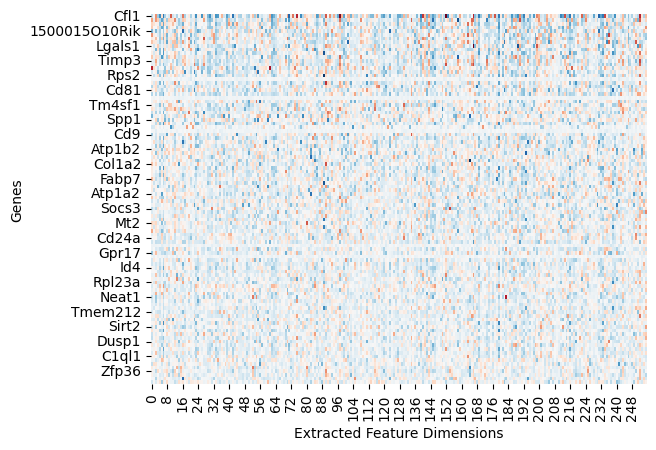

In [11]:
import pandas as pd

n_top = 100
feature_gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
# index_list = list(np.argsort(feature_gcn_weight.mean(axis=0))[::-1][:n_top])  # 权重最大的前几个
index_list = list(np.argsort(np.abs(feature_gcn_weight).mean(axis=0))[::-1][:n_top])  # 权重绝对值最大的前几个
print(index_list)

gene_index_list = []
for index in index_list:
    if index > 2000:
        index = index-2000
    gene_index_list.append(index)

# 添加基因名
gene_name_list = list(adata.var.iloc[gene_index_list].index)
feature_df = pd.DataFrame(gcn_weight[:, gene_index_list].T)
feature_df.index = gene_name_list

sns.heatmap(feature_df, cmap="RdBu_r", cbar=False)  # 不要颜色条
plt.xlabel("Extracted Feature Dimensions")
plt.ylabel("Genes")

feature_df # 这些基因就可以作为候选的标记基因了

In [26]:
# 保存前几个基因
pd.Series(feature_df.index).to_csv("output/top%s.csv"%n_top, index=0, header=None)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Cfl1,-0.227378,0.086736,0.572894,-0.359856,-0.654603,0.238810,-0.776138,-0.330267,-0.010477,-0.146687,...,-0.429499,-0.060746,-0.312068,0.080815,-0.119945,-0.276146,0.950588,0.197802,-0.330851,0.418010
Tubb5,0.521104,-0.069721,0.555989,0.350687,-0.268375,-0.552541,-0.383088,0.224557,-0.366191,0.333146,...,-0.319419,-0.138270,0.010663,-0.375906,0.474602,-0.480065,0.758781,0.149076,-0.074472,0.311113
Marcks,0.309987,0.230257,0.099816,0.123641,-0.403279,0.297846,-0.544877,0.267891,-0.127328,0.193442,...,-0.054396,-0.117953,-0.276612,0.393178,-0.061211,0.148881,0.305610,-0.088083,-0.014598,-0.145878
Arl6ip1,0.352272,0.059474,0.045934,0.253631,-0.259098,-0.538762,-0.443990,0.073448,-0.441102,0.284157,...,-0.514163,-0.032040,0.011067,-0.248721,0.081328,-0.182584,0.004476,0.060422,-0.034307,0.575691
1500015O10Rik,-0.464405,-0.033285,-0.469045,-0.128438,-0.340098,0.031459,-0.360612,0.083039,0.338293,-0.108605,...,0.352391,0.126745,-0.303884,0.371805,-0.199694,-0.011273,-0.057656,-0.151569,0.385813,0.157833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fosb,0.146836,0.020780,0.133959,0.016475,-0.052034,-0.036922,0.059656,-0.008814,0.145647,-0.068435,...,-0.147487,-0.060226,-0.131125,-0.268461,0.173713,0.081181,0.198134,-0.047026,-0.040339,-0.025607
Zfp36,0.101227,-0.003837,-0.247610,0.269991,0.085450,-0.078656,0.158288,0.205345,0.299325,-0.066531,...,-0.001793,-0.004905,-0.010484,-0.021078,-0.305874,0.075151,0.432825,-0.037041,-0.213889,0.037564
Nr4a1,0.106459,-0.044536,-0.042573,0.058353,-0.124287,-0.075209,-0.140129,0.052650,0.220897,-0.319297,...,-0.109762,-0.000053,-0.023110,-0.153956,0.043687,0.003716,0.425247,-0.035965,-0.089246,-0.277001
Rarres2,0.034578,0.039081,-0.288016,0.100164,-0.060940,-0.003227,-0.090565,0.238384,0.084936,0.069079,...,0.029587,0.024365,-0.056325,-0.030709,0.173780,-0.247383,0.440597,-0.110047,0.310341,-0.144853


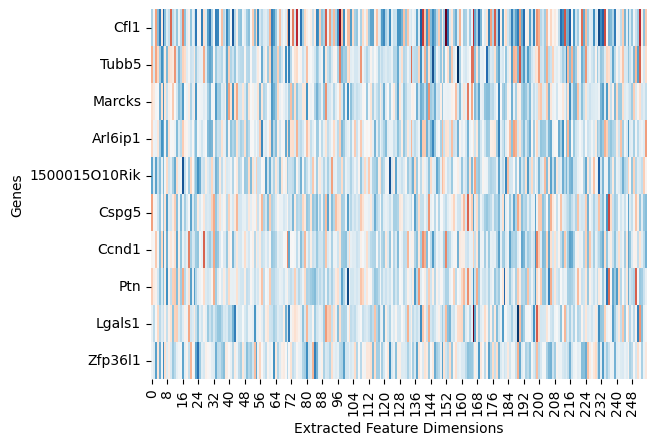

In [12]:
sns.heatmap(feature_df[:10], cmap="RdBu_r", cbar=False)  # 不要颜色条
plt.xlabel("Extracted Feature Dimensions")
plt.ylabel("Genes")

feature_df # 这些基因就可以作为候选的标记基因了

2. 提取与Cfl1相关性很强的特征

In [9]:
top_n = 2
gene = "Cfl1"
positive_feature_index_list = list(np.argsort(feature_df.loc[gene])[::-1][:top_n]) # 与Hbb-y相关的特征
negtive_feature_index_list = list(np.argsort(feature_df.loc[gene])[:top_n]) # Hbb-y负相关的特征

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

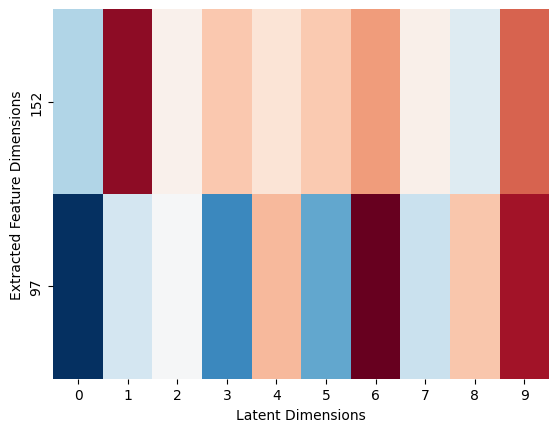

In [10]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, positive_feature_index_list].T)
df.index = positive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

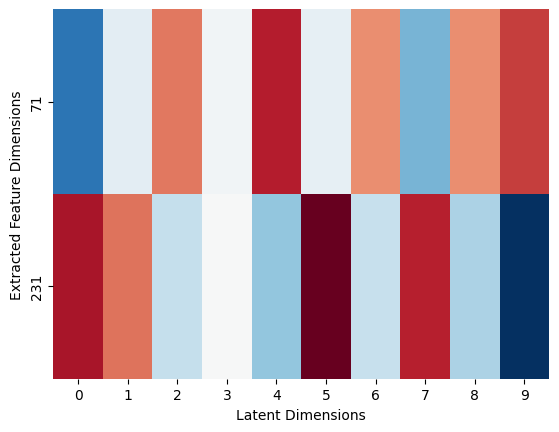

In [11]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, negtive_feature_index_list].T)
df.index = negtive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")